In [15]:
pip install opendatasets

In [16]:
import opendatasets as od
import os
od.download("https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images")

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
import torch.optim as optim
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

Skipping, found downloaded files in "./pokemon-sprites-images" (use force=True to force download)


In [17]:
class PokemonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []

        for pokemon_name in os.listdir(root_dir):
            front_normal_path = os.path.join(root_dir, pokemon_name, "front", "normal")
            if os.path.exists(front_normal_path):
                for file in os.listdir(front_normal_path):
                    if file.endswith(".png") or file.endswith(".jpg"):
                        self.images.append(os.path.join(front_normal_path, file))
                        break

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, 0

In [18]:
print(os.listdir("./pokemon-sprites-images/pokemon_images/sprites")[:5])

['0525-Combee-415', '0738-Lampent-608', '0170-Chansey-113', '1051-Toxtricity Low Key-849', '0736-Beheeyem-606']


In [19]:
def sinusoidal_embedding(timesteps: torch.LongTensor, dim: int):
    """
    timesteps: (B,) long tensor
    returns: (B, dim) float tensor
    """
    assert len(timesteps.shape) == 1
    device = timesteps.device
    half = dim // 2
    freqs = torch.exp(-torch.log(torch.tensor(10000.0, device=device)) * torch.arange(half, device=device) / (half - 1))
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

In [20]:
transform = T.Compose([
    T.Resize((96, 96), interpolation=Image.NEAREST),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = PokemonDataset(root_dir="./pokemon-sprites-images/pokemon_images/sprites", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [21]:
class ConvBlock(nn.Module):
    """
    Standard convolutional block with GroupNorm, SiLU activation,
    a residual connection, and time embedding injection.
    """
    def __init__(self, in_ch, out_ch, time_emb_dim, is_res=True):
        super().__init__()
        self.is_res = is_res
        self.main_path = nn.Sequential(
            nn.GroupNorm(8, in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
        )
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch),
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, temb):
        h = self.main_path(x)
        time_emb = self.time_mlp(temb).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb
        return h + self.res_conv(x)

In [22]:
class AttentionBlock(nn.Module):
    """
    Self-attention block. Applies Multi-Head Self-Attention to 2D feature maps.
    """
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1, bias=False)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.norm(x)
        qkv = self.qkv(x).reshape(B, 3, self.num_heads, C // self.num_heads, H * W)
        q, k, v = qkv.unbind(1)

        attn = torch.einsum('b h c i, b h c j -> b h i j', q, k) * ((C // self.num_heads) ** -0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.einsum('b h i j, b h c j -> b h c i', attn, v)
        out = out.reshape(B, C, H, W)
        return x + self.proj(out)

In [23]:
class UNet(nn.Module):
    def __init__(self, img_channels=3, base_channels=128, time_emb_dim=256):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        ch_mults = (1, 2, 4, 8)
        channels = [base_channels] + [base_channels * m for m in ch_mults]

        self.init_conv = nn.Conv2d(img_channels, base_channels, 3, padding=1)

        self.down_blocks = nn.ModuleList()
        for i in range(len(ch_mults)):
            in_ch = channels[i]
            out_ch = channels[i+1]
            self.down_blocks.append(nn.ModuleList([
                ConvBlock(in_ch, out_ch, time_emb_dim),
                AttentionBlock(out_ch) if i >= 2 else nn.Identity(),
                nn.Conv2d(out_ch, out_ch, 4, stride=2, padding=1)
            ]))

        self.mid_block1 = ConvBlock(channels[-1], channels[-1], time_emb_dim)
        self.mid_attn = AttentionBlock(channels[-1])
        self.mid_block2 = ConvBlock(channels[-1], channels[-1], time_emb_dim)

        self.up_blocks = nn.ModuleList()
        for i in reversed(range(len(ch_mults))):
            in_ch = channels[i+1]
            out_ch = channels[i]

            self.up_blocks.append(nn.ModuleList([
                nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1),
                ConvBlock(out_ch + in_ch, out_ch, time_emb_dim),
                AttentionBlock(out_ch) if i >= 2 else nn.Identity(),
            ]))

        self.final_norm = nn.GroupNorm(8, base_channels)
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(base_channels, img_channels, 1)

    def forward(self, x, t):
        temb = sinusoidal_embedding(t, 256)
        temb = self.time_mlp(temb)

        x = self.init_conv(x)

        skips = [x]
        for block, attn, downsample in self.down_blocks:
            x = block(x, temb)
            x = attn(x)
            skips.append(x)
            x = downsample(x)

        x = self.mid_block1(x, temb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, temb)

        for upsample, block, attn in self.up_blocks:
            x = upsample(x)
            skip = skips.pop()
            x = torch.cat([x, skip], dim=1)
            x = block(x, temb)
            x = attn(x)

        x = self.final_norm(x)
        x = self.final_act(x)
        return self.final_conv(x)

In [24]:
class Diffusion:
    def __init__(self, model: nn.Module, img_size=96, device="cuda", timesteps=256):
        self.model = model
        self.img_size = img_size
        self.device = device
        self.timesteps = timesteps

        betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.betas = betas
        self.alphas = alphas
        self.alphas_cumprod = alphas_cumprod
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]])

        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    def q_sample(self, x0, t, noise=None):
        """
        sample from q(x_t | x_0)
        x0: (B,C,H,W)
        t: (B,) long tensor
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise

    def training_step(self, x0):
        """
        single batch training step: pick random t for each sample
        returns MSE loss between predicted noise and real noise
        """
        b = x0.size(0)
        t = torch.randint(0, self.timesteps, (b,), device=self.device, dtype=torch.long)
        noise = torch.randn_like(x0)
        x_noisy = self.q_sample(x0, t, noise)
        noise_pred = self.model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)
        return loss

    def p_mean_variance(self, x_t, t):
        """
        computes posterior mean and variance for q(x_{t-1} | x_t, x0_pred)
        x_t: (B,C,H,W)
        t: scalar int or 0-d python int
        returns: posterior_mean, posterior_variance (both tensors shape (B,C,H,W) for mean and (B,1,1,1) for var)
        """
        B = x_t.shape[0]
        device = x_t.device
        t_tensor = torch.full((B,), t, device=device, dtype=torch.long)
        eps_theta = self.model(x_t, t_tensor)

        sqrt_alpha_hat_t = self.sqrt_alphas_cumprod[t]
        sqrt_one_minus_alpha_hat_t = self.sqrt_one_minus_alphas_cumprod[t]
        x0_pred = (x_t - sqrt_one_minus_alpha_hat_t * eps_theta) / sqrt_alpha_hat_t
        x0_pred = torch.clamp(x0_pred, -1.0, 1.0)

        alpha_t = self.alphas[t]
        alpha_hat_t = self.alphas_cumprod[t]
        alpha_hat_prev = self.alphas_cumprod_prev[t]
        beta_t = self.betas[t]

        coef_x0 = (torch.sqrt(alpha_hat_prev) * beta_t) / (1.0 - alpha_hat_t)
        coef_xt = (torch.sqrt(alpha_t) * (1.0 - alpha_hat_prev)) / (1.0 - alpha_hat_t)

        coef_x0 = coef_x0.view(1, 1, 1, 1)
        coef_xt = coef_xt.view(1, 1, 1, 1)

        posterior_mean = coef_x0 * x0_pred + coef_xt * x_t
        posterior_variance = beta_t * (1.0 - alpha_hat_prev) / (1.0 - alpha_hat_t)
        posterior_log_variance = torch.log(torch.clamp(posterior_variance, min=1e-20)).view(1, 1, 1, 1)

        return posterior_mean, posterior_variance, posterior_log_variance

    def p_sample(self, x_t, t):
        """
        sample x_{t-1} from p(x_{t-1} | x_t)
        """
        mean, var, log_var = self.p_mean_variance(x_t, t)
        if t == 0:
            return mean
        noise = torch.randn_like(x_t)
        return mean + torch.sqrt(var).view(1,1,1,1) * noise

    def sample(self, batch_size=8):
        """
        Full sampling loop: start from x_T ~ N(0,I), run p_sample iteratively.
        """
        x = torch.randn(batch_size, 3, self.img_size, self.img_size, device=self.device)
        for t in reversed(range(self.timesteps)):
            x = self.p_sample(x, t)
        return x

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(img_channels=3, base_channels=128, time_emb_dim=256).to(device)
diffusion = Diffusion(model, img_size=96, device=device, timesteps=1000)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

tensor([-1.0000, -0.9922, -0.9373, -0.9216, -0.8745, -0.8510, -0.8275, -0.8196,
        -0.8118, -0.8039, -0.7882, -0.7804, -0.7725, -0.7569, -0.7490, -0.7412,
        -0.7333, -0.7176, -0.7098, -0.7020, -0.6941, -0.6863, -0.6784, -0.6627,
        -0.6549, -0.6471, -0.6392, -0.6314, -0.6235, -0.6157, -0.6078, -0.6000,
        -0.5922, -0.5765, -0.5686, -0.5608, -0.5529, -0.5451, -0.5216, -0.5059,
        -0.4980, -0.4902, -0.4824, -0.4745, -0.4667, -0.4510, -0.4431, -0.4353,
        -0.4275, -0.4196, -0.3961, -0.3804, -0.3725, -0.3569, -0.3490, -0.3412,
        -0.3255, -0.3176, -0.3098, -0.3020, -0.2941, -0.2863, -0.2784, -0.2627,
        -0.2549, -0.2471, -0.2392, -0.2314, -0.2235, -0.2078, -0.1922, -0.1843,
        -0.1765, -0.1686, -0.1608, -0.1294, -0.1216, -0.1137, -0.0980, -0.0745,
        -0.0588, -0.0353, -0.0275, -0.0118, -0.0039,  0.0039,  0.0118,  0.0275,
         0.0353,  0.0431,  0.0588,  0.0667,  0.0745,  0.0824,  0.0902,  0.0980,
         0.1137,  0.1294,  0.1373,  0.14

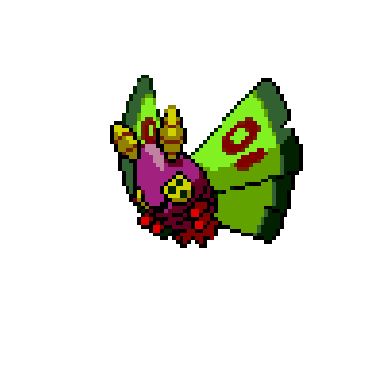

In [26]:
img, _ = next(iter(dataloader))
print(torch.unique(img))
plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

In [ ]:
num_epochs = 3500
iters = 0
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        loss = diffusion.training_step(imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iters += 1
        pbar.set_postfix({"loss": loss.item(), "iters": iters})

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            samples = diffusion.sample(batch_size=8)
            samples = (samples * 0.5 + 0.5).clamp(0, 1)
        model.train()

        fig, axes = plt.subplots(1, 8, figsize=(16, 2))
        for i in range(8):
            img = samples[i].permute(1, 2, 0).cpu().numpy()
            axes[i].imshow(img)
            axes[i].axis("off")
        plt.show()

Epoch 52/3500:  12%|█▏        | 4/34 [00:03<00:27,  1.09it/s, loss=0.0273, iters=1738]

In [ ]:
with torch.no_grad():
    samples = diffusion.sample(batch_size=8)
    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for i in range(8):
        axes[i].imshow(samples[i].permute(1, 2, 0).cpu().numpy())
        axes[i].axis("off")
    plt.show()

In [ ]:
torch.save(model.state_dict(), "unet_pokemon_diffusion.pth")